In [1]:
from utils import *
from evaluation_functions import *
from torchvision_models import *

import pickle 
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader



import pytorch_lightning as pl
import mlflow

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()
torch.set_float32_matmul_precision('medium')#gpu precision

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

%load_ext autoreload
%autoreload 2

# ----------------
isSmallDataset = True
testing = True




cpu


In [2]:
add = os.getcwd()+'/.data'
def getData(add,download=False):
    train_set = torchvision.datasets.CIFAR100(root = add, train = True, download = download, transform = torchvision.transforms.ToTensor())
    val_set = torchvision.datasets.CIFAR100(root = add, train = False, download = download, transform = torchvision.transforms.ToTensor())
    return train_set,val_set
    
try:
    train_set,val_set = getData(add,download=False)
except:
    train_set,val_set = getData(add,download=True)

# # subsample
class_to_idx = train_set.class_to_idx
# train_set = torch.utils.data.Subset(train_set,torch.arange(100)) if isSmallDataset else train_set
# val_set = torch.utils.data.Subset(val_set,torch.arange(100)) if isSmallDataset else val_set


# y=[]
# for [xx1,yy1],[xx2,yy2] in zip(train_set,val_set):
#     y+=[yy1,yy2]
# y = np.unique(y)
num_classes = len(class_to_idx)
class_names ={}
class_transform = {}
for key,value in class_to_idx.items():
    class_names[value] = key
    class_transform[value] = value# if classe are not numbered from 0 to n-1 consecutively
    # print(key,value)
class_info = (class_names,class_transform)
# class_info

In [13]:
batch_size = 2**5
num_workers= 4 if device.type != 'cuda:0' else 16
DataLoaderParams = {'num_workers': num_workers, 'drop_last':True, 'persistent_workers':True,}

sampler = None
Datasets = {
    'train': train_set,
    'val': val_set,
    'DataLoaderParams': DataLoaderParams,
    'sampler': sampler,
    'class_info':class_info,
    'isSmallDataset': isSmallDataset
}
dataloaders = {
                'train': DataLoader(Datasets['train'],**Datasets['DataLoaderParams'],sampler=Datasets['sampler'],batch_size=batch_size),
                'val': DataLoader(Datasets['val'],**Datasets['DataLoaderParams'],shuffle = False,batch_size=batch_size)}


In [14]:
y =[]
for i ,[_,yy] in enumerate(dataloaders['train']):
    y += yy.tolist()
    # print(f'batch {type(yy.tolist())} loaded')
    # break

In [18]:
len(np.unique(y))

100

batch 0 loaded


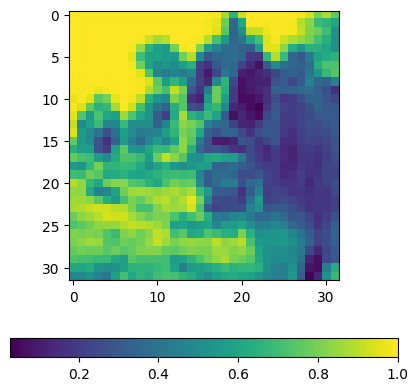

In [5]:
for i ,[xx,yy] in enumerate(dataloaders['train']):
    print(f'batch {i} loaded')
    # if i>0:
    break

fig,ax = plt.subplots(figsize=(5,5))
im = ax.imshow(xx[0,1,:,:])
# im = ax.imshow(xx[0,:,:,:],cmap='gray')
fig.colorbar(im,ax=ax,orientation='horizontal')

mlflow - connect to experiment

In [6]:
experiment_name = 'torchvision_models'
mlflow.set_experiment(experiment_name)
# mlflow.set_tracking_uri('file:/home/riccardo/mlruns')

<Experiment: artifact_location='file:///c:/Users/yili0901/Documents/GitHub/train_predefined_models/mlruns/616396183234793699', creation_time=1701618008066, experiment_id='616396183234793699', last_update_time=1701618008066, lifecycle_stage='active', name='torchvision_models', tags={}>

hyper parameters

In [7]:
from utils import *
testing = True
if testing:
    hparams = {
        'model_name': ['resnet18'],
        'lr': [0.1],
        'scheduler_step': [None],
        'optimizer': ['Adam'],
        'epochs': [1],
        'batch_size': [2**2],
        'weights': [None],
        'criterion': ['CrossEntropyLoss'],
    }
else:

    hparams = {
        'model_name': ['resnet18','resnet50'],
        'lr': [0.1,0.01],
        'scheduler_step': [None,30],
        'optimizer': ['Adam','SGD'],
        'epochs': [1],
        'batch_size': [2**7],
        'weights': [None],
        'criterion': ['CrossEntropyLoss'],
    }
hparams = calc_hparams(hparams, shuffle=False)

{'model_name': 'resnet18', 'lr': 0.1, 'scheduler_step': None, 'optimizer': 'Adam', 'epochs': 1, 'batch_size': 4, 'weights': None, 'criterion': 'CrossEntropyLoss'}


In [8]:
def train_model(Datasets, device, epochs,num_classes=2,lr=0.01,optimizer = 'Adam',model_name='resnet18', weights=None, batch_size=2**2, criterion='CrossEntropyLoss',scheduler_step=None):
    run_name = f'{model_name}_{optimizer}_{criterion}_{lr}_{batch_size}_scheduler_step_{scheduler_step}_weights_{weights}'
    print ('-'*150)

    print(f'Initiating {run_name}')
    model = get_model_lightning(model_name,num_classes, optimizer, lr, weights, criterion, scheduler_step).to(device)
    # create dataloaders from predefined datasets
    dataloaders = {
                'train': DataLoader(Datasets['train'],**Datasets['DataLoaderParams'],sampler=Datasets['sampler'],batch_size=batch_size),
                'val': DataLoader(Datasets['val'],**Datasets['DataLoaderParams'],shuffle = False,batch_size=batch_size)
                }
    pl.seed_everything(42,workers=True)
    pl_accelerator = device.type if device.type != 'cuda:0' else 'gpu'#'auto' can be used for automatic choice
    trainer = pl.Trainer(max_epochs=epochs, log_every_n_steps=1,enable_checkpointing=False,precision='bf16-mixed',
                         deterministic=True,accelerator=pl_accelerator, devices='auto',#devices='0,1' for multiple gpus
                         limit_train_batches=0.05,limit_val_batches=0.05,limit_test_batches=0.05,)#percentage of dataset batches used in epoch

    print ('Training start')  
    mlflow.start_run(run_name=run_name)
    mlflow.pytorch.autolog(registered_model_name=model_name,silent=False)#log all parameters - works only with pytorch lightning
    mlflow.log_params({'model': model_name,'batch_size': batch_size,'pretrain_weights': weights,'criterion': criterion,'optimizer':optimizer, 
                       'epochs': epochs,'scheduler_step': scheduler_step})
    trainer.fit(model, train_dataloaders = dataloaders['train'], val_dataloaders =dataloaders['val'])
    print ('Training complete')
    # ----------------------------------
    print('Predicting (test) start')
    y_pred_test,y_true_test = seperate_predictions(trainer.predict(model,dataloaders['val']))#y_pred_test,y_true_test are recieved by batch of both needs to be restructured
    test_metrics = evaluate_metrics(y_true_test,y_pred_test)
    print(test_metrics)

    # calculate confusion matrix,classification report 
    eval_metric_figs(y_pred_test,y_true_test,num_classes,class_names=class_info[0],class_transform=class_info[1], save=True,folder_name=run_name)   
    
    mlflow.log_metrics(test_metrics)
    mlflow.end_run() 
    return model,trainer             

mlflow.end_run()
train_model(Datasets, device, epochs=1,num_classes=2,lr=0.01,optimizer = 'Adam',model_name='resnet18', weights=None, batch_size=2**2, criterion='CrossEntropyLoss',scheduler_step=None)
   

Seed set to 42


------------------------------------------------------------------------------------------------------------------------------------------------------
Initiating resnet18_Adam_CrossEntropyLoss_0.01_4_scheduler_step_None_weights_None


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/12/03 18:59:17 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Training start



  | Name       | Type               | Params
--------------------------------------------------
0 | back_bone  | ResNet             | 11.2 M
1 | criterion_ | CrossEntropyLoss   | 0     
2 | train_acc  | MulticlassAccuracy | 0     
3 | val_acc    | MulticlassAccuracy | 0     
4 | test_acc   | MulticlassAccuracy | 0     
--------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

IndexError: Target 49 is out of bounds.

In [ ]:
for p in hparams:
    print('-'*150)
    print('-'*150)
    print(p)
    
    model,trainer = train_model(Datasets.copy(), device, num_classes, **p)

------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
{'model_name': 'resnet18', 'lr': 0.1, 'scheduler_step': None, 'optimizer': 'Adam', 'epochs': 1, 'batch_size': 4, 'weights': None, 'criterion': 'CrossEntropyLoss'}


TypeError: train_model() got multiple values for argument 'epochs'